In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap
import ipyvolume as ipv

## Data retrieval

In [3]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


## Data loading

In [4]:
#@title Data loading

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
print(alldat[11].keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


## Function for neuron selection

In [5]:
def neurons_from_area(area, alldat, neuron_type='exc'):
    # neuron_type: 'exc' - firing rate increase after stimulation, 'inh' -- decrease, 'all' -- all
    
    V1stim_neurons_rec = []
    stim_neurons_rec = []
    
    for record in range(len(alldat)):
        
        dat = alldat[record]
        V1_stim_neurons = []
        stim_neurons = []
        
        times = np.arange(0, 2.5, 0.01) # recording times
        
        nogo_trials = []
        for i in range(dat['spks'].shape[1]):
            if dat['contrast_left'][i] == 0 and dat['contrast_right'][i] == 0:
                nogo_trials.append(i)
        
        for i_neuron in range(dat['spks'].shape[0]):
            
            prestim = [] # intervals before the stimulus onset
            poststim = [] # intervals from stimulus onset to mouse response

            for trial in range(dat['spks'].shape[1]):
      
                # exclude NoGo trials
                if trial not in nogo_trials:
                    
                    # 0.5 sec - time of visual stimulus onset
                    # gocue - is auditory stimulus, which usually follows the visual one
                    if dat['gocue'][trial] > 0.5:
                        cue = dat['gocue'][trial]
                    else:
                        cue = 0.5
                    resp = dat['response_time'][trial]

                    # time index of stimulus onset
                    cue_i = (np.abs(times - cue)).argmin()

                    # time index of response
                    resp_i = (np.abs(times - resp)).argmin()

                    # append number of spikes normalized by a time period ("frequency")
                    prestim.append(np.sum(dat['spks'][i_neuron, trial, :cue_i]) / times[cue_i-1])
                    poststim.append(np.sum(dat['spks'][i_neuron, trial, cue_i:resp_i]) / (times[resp_i]-times[cue_i]))
        

            # exclude nan values from lists (часототы для данного нейрона на разных триалах до и после стимуляции)
            prestim = [pr for pr in prestim if str(pr) != 'nan']
            poststim = [pr for pr in poststim if str(pr) != 'nan']
        
            # add neuron index to stim_neurons if average spike frequency during stimulus time period
            # is greater than average spike frequency during interstimulus time interval
            if neuron_type == 'exc': 
                if np.mean(poststim) > np.mean(prestim): # мб любой парный стат-тест на матожидание (вилкоксона) 
                    stim_neurons.append(i_neuron)
            elif neuron_type == 'inh':
                if np.mean(poststim) < np.mean(prestim): # также стат-тест
                    stim_neurons.append(i_neuron)
            else:
                stim_neurons.append(i_neuron) # можно добавить вариант с двусторонним тестом
           
          
        # choose neurons from area:
        for neuron_i in range(len(stim_neurons)):
            if dat['brain_area'][stim_neurons[neuron_i]] == area:
                V1_stim_neurons.append(stim_neurons[neuron_i])

        V1stim_neurons_rec.append(V1_stim_neurons)
        stim_neurons_rec.append(stim_neurons) 
        
#         break
        
    return np.array(V1stim_neurons_rec)

## Firing rate calculation

In [6]:
def firing_rate(spikes, window=5):
    return np.stack(
        [np.sum(spikes[..., i - window:i], -1) / (10 * window) * 1000 
         for i in range(window, spikes.shape[-1])],
        -1
    )

## Main function 
### Implementation of PCA pipeline 

In [7]:
def pca_from_spikes(area, record, alldat, neuron_type='exc',):
    
    neurons = neurons_from_area(area, alldat, neuron_type)   
    
    spikes_ntt = alldat[record]['spks'][neurons[record]]
    
    firing_rates_ntt = np.array([firing_rate(spike) for spike in spikes_ntt])
    firing_rates_nt = np.mean(firing_rates_ntt, axis=1)

    pre_firing_rate = firing_rates_nt[:,:50].reshape((firing_rates_nt.shape[0], -1)).T
    post_firing_rate = firing_rates_nt[:,50:].reshape((firing_rates_nt.shape[0], -1)).T
    firing_rates_tn = firing_rates_nt.reshape((firing_rates_nt.shape[0], -1)).T

    pca = PCA()
    pca.fit(firing_rates_tn)
    
    print(f'Explained variance ratio: {np.sum(pca.explained_variance_ratio_[:3])}')

    X = pca.transform(pre_firing_rate)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5, c='b')
    plt.plot(X[:, 0], X[:, 1], alpha=0.5, c='b')
    
    X = pca.transform(post_firing_rate)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5, c='r')
    plt.plot(X[:, 0], X[:, 1], alpha=0.5, c='r')
    plt.show()

    fig = plt.figure(1, figsize=(14, 10))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    X = pca.transform(pre_firing_rate)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=plt.cm.nipy_spectral,
               edgecolor='k', c='r')
    ax.plot(X[:, 0], X[:, 1], X[:, 2], c='b')

    X = pca.transform(post_firing_rate)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=plt.cm.nipy_spectral,
               edgecolor='k', c='r')
    ax.plot(X[:, 0], X[:, 1], X[:, 2], c='r')
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

    plt.show()

## Example

/home/xomaiya/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Explained variance ratio: 0.7872364253498769


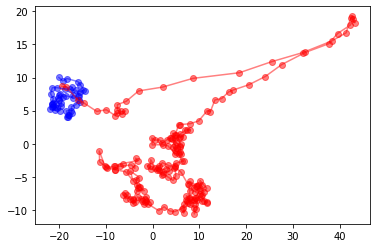

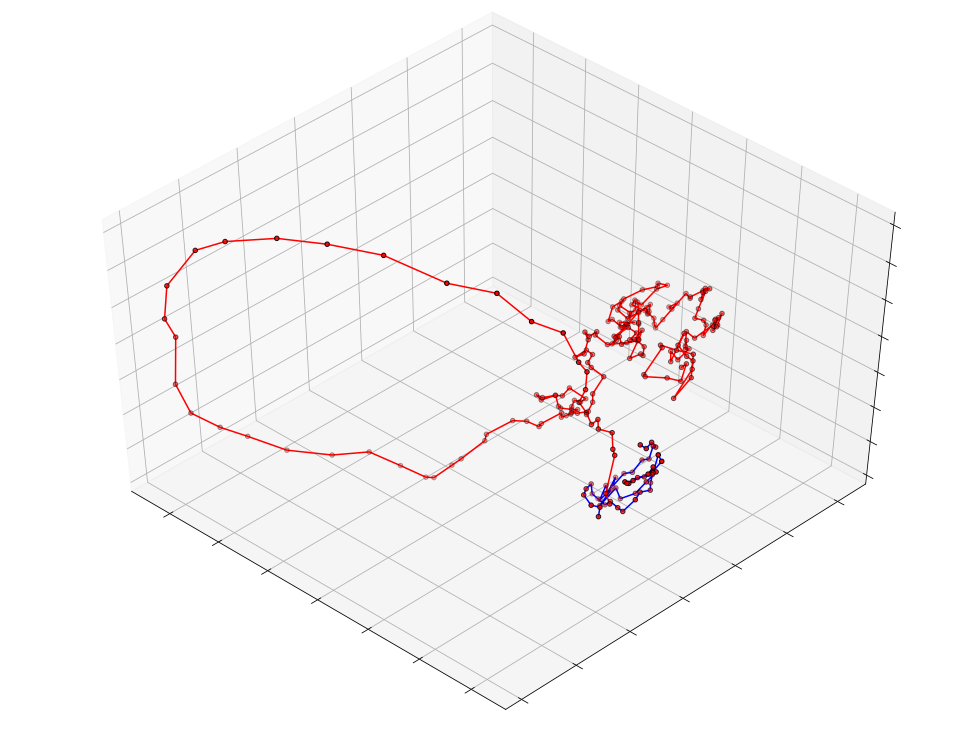

In [8]:
pca_from_spikes(area='VISp', record=0, alldat=alldat, neuron_type='exc')